# Document Visual Question Answering Using Pix2Struct and OpenVINO™

DocVQA (Document Visual Question Answering) is a research field in computer vision and natural language processing that focuses on developing algorithms to answer questions related to the content of a document represented in image format, like a scanned document, screenshots, or an image of a text document. Unlike other types of visual question answering, where the focus is on answering questions related to images or videos, DocVQA is focused on understanding and answering questions based on the text and layout of a document. The questions can be about any aspect of the document text. DocVQA requires understanding the document’s visual content and the ability to read and comprehend the text in it.

DocVQA offers several benefits compared to OCR (Optical Character Recognition) technology:
* Firstly, DocVQA can not only recognize and extract text from a document, but it can also understand the context in which the text appears. This means it can answer questions about the document’s content rather than simply provide a digital version.
* Secondly, DocVQA can handle documents with complex layouts and structures, like tables and diagrams, which can be challenging for traditional OCR systems.
* Finally, DocVQA can automate many document-based workflows, like document routing and approval processes, to make employees focus on more meaningful work. The potential applications of DocVQA include automating tasks like information retrieval, document analysis, and document summarization.

[Pix2Struct](https://arxiv.org/pdf/2210.03347.pdf) is a multimodal model for understanding visually situated language that easily copes with extracting information from images. The model is trained using the novel learning technique to parse masked screenshots of web pages into simplified HTML, providing a significantly well-suited pretraining data source for the range of downstream activities such as OCR, visual question answering, and image captioning.

In this tutorial, we consider how to run the Pix2Struct model using OpenVINO for solving document visual question answering task. We will use a pre-trained model from the [Hugging Face Transformers](https://huggingface.co/docs/transformers/index) library. To simplify the user experience, the [Hugging Face Optimum](https://huggingface.co/docs/optimum) library is used to convert the model to OpenVINO™ IR format.


#### Table of contents:

- [About Pix2Struct](#About-Pix2Struct)
- [Prerequisites](#Prerequisites)
- [Download and Convert Model](#Download-and-Convert-Model)
- [Select inference device](#Select-inference-device)
- [Test model inference](#Test-model-inference)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/pix2struct-docvqa/pix2struct-docvqa.ipynb" />


## About Pix2Struct
[back to top ⬆️](#Table-of-contents:)

Pix2Struct is an image encoder - text decoder model that is trained on image-text pairs for various tasks, including image captioning and visual question answering. The model combines the simplicity of purely pixel-level inputs with the generality and scalability provided by self-supervised pretraining from diverse and abundant web data. The model does this by recommending a screenshot parsing objective that needs predicting an HTML-based parse from a screenshot of a web page that has been partially masked. With the diversity and complexity of textual and visual elements found on the web, Pix2Struct learns rich representations of the underlying structure of web pages, which can effectively transfer to various downstream visual language understanding tasks.

Pix2Struct is based on the Vision Transformer (ViT), an image-encoder-text-decoder model with changes in input representation to make the model more robust to processing images with various aspect ratios. Standard ViT extracts fixed-size patches after scaling input images to a predetermined resolution. This distorts the proper aspect ratio of the image, which can be highly variable for documents, mobile UIs, and figures. Pix2Struct proposes to scale the input image up or down to extract the maximum number of patches that fit within the given sequence length. This approach is more robust to extreme aspect ratios, common in the domains Pix2Struct experiments with. Additionally, the model can handle on-the-fly changes to the sequence length and resolution. To handle variable resolutions unambiguously, 2-dimensional absolute positional embeddings are used for the input patches.

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

First, we need to install the [Hugging Face Optimum](https://huggingface.co/docs/transformers/index) library accelerated by OpenVINO integration.
The Hugging Face Optimum API is a high-level API that enables us to convert and quantize models from the Hugging Face Transformers library to the OpenVINO™ IR format. For more details, refer to the [Hugging Face Optimum documentation](https://huggingface.co/docs/optimum/intel/inference).

In [1]:
%pip install -q "torch>=2.1" torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
%pip install -q "git+https://github.com/huggingface/optimum-intel.git" "openvino>=2023.1.0" "onnx<1.16.2" "gradio>=4.19" --extra-index-url https://download.pytorch.org/whl/cpu

## Download and Convert Model
[back to top ⬆️](#Table-of-contents:)

Optimum Intel can be used to load optimized models from the [Hugging Face Hub](https://huggingface.co/docs/optimum/intel/hf.co/models) and create pipelines to run an inference with OpenVINO Runtime using Hugging Face APIs. The Optimum Inference models are API compatible with Hugging Face Transformers models.  This means we just need to replace the `AutoModelForXxx` class with the corresponding `OVModelForXxx` class.

Model class initialization starts with calling the `from_pretrained` method. When downloading and converting the Transformers model, the parameter `export=True` should be added. We can save the converted model for the next usage with the `save_pretrained` method. After model saving using the `save_pretrained` method, you can load your converted model without the `export` parameter, avoiding model conversion for the next time. For reducing memory consumption, we can compress model to float16 using `half()` method.

In this tutorial, we separate model export and loading for a demonstration of how to work with the model in both modes.
We will use the [pix2struct-docvqa-base](https://huggingface.co/google/pix2struct-docvqa-base) model as an example in this tutorial, but the same steps for running are applicable for other models from pix2struct family.

In [ ]:
import gc
from pathlib import Path
from optimum.intel.openvino import OVModelForPix2Struct

model_id = "google/pix2struct-docvqa-base"
model_dir = Path(model_id.split("/")[-1])

if not model_dir.exists():
    ov_model = OVModelForPix2Struct.from_pretrained(model_id, export=True, compile=False)
    ov_model.half()
    ov_model.save_pretrained(model_dir)
    del ov_model
    gc.collect();

## Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [3]:
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)
open("notebook_utils.py", "w").write(r.text)

from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

## Test model inference
[back to top ⬆️](#Table-of-contents:)

The diagram below demonstrates how the model works:
![pix2struct_diagram.png](https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/c7456b17-0687-4aa9-851b-267bff3dac79)

For running model inference we should preprocess data first. `Pix2StructProcessor` is responsible for preparing input data and decoding output for the original PyTorch model and easily can be reused for running with the Optimum Intel model. Then `OVModelForPix2Struct.generate` method will launch answer generation. Finally, generated answer token indices should be decoded in text format by `Pix2StructProcessor.decode`

In [4]:
from transformers import Pix2StructProcessor

processor = Pix2StructProcessor.from_pretrained(model_id)
ov_model = OVModelForPix2Struct.from_pretrained(model_dir, device=device.value)

Compiling the encoder to AUTO ...
Compiling the decoder to AUTO ...
Compiling the decoder to AUTO ...


Let's see the model in action. For testing the model, we will use a screenshot from [OpenVINO documentation](https://docs.openvino.ai/2024/get-started.html#openvino-advanced-features)

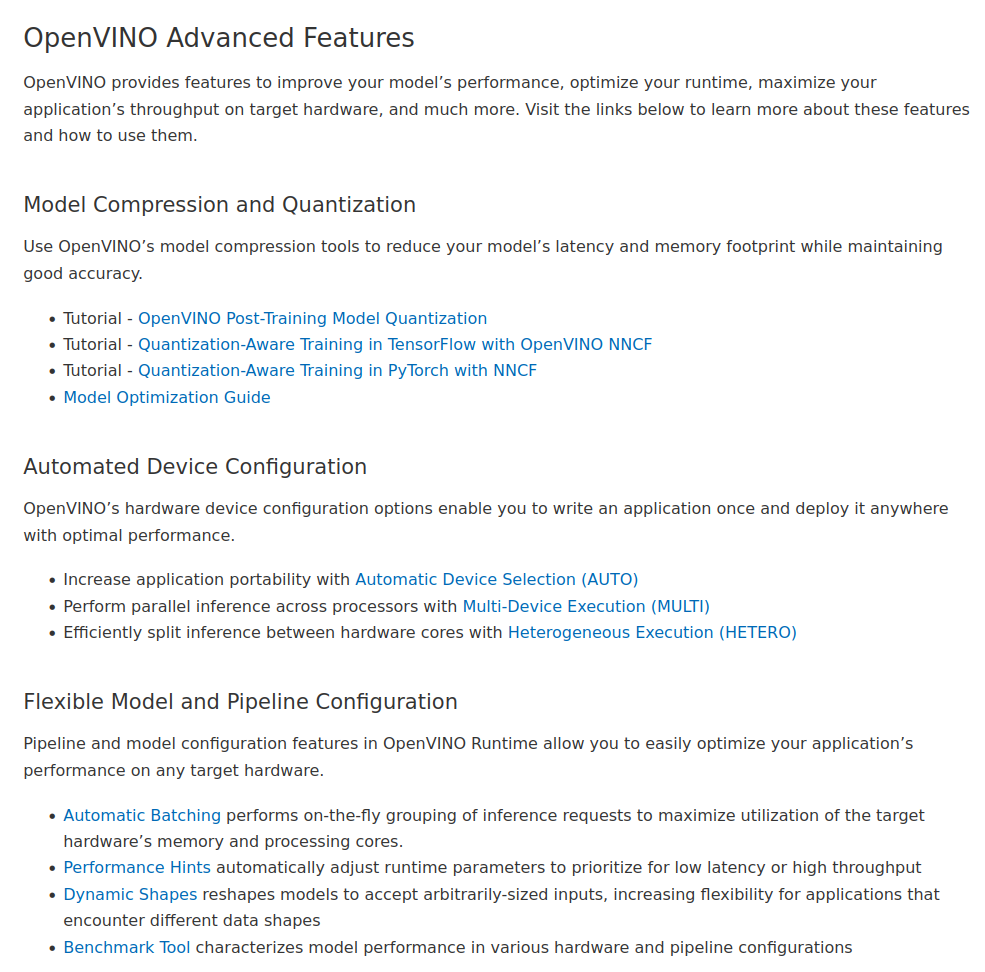

In [5]:
import requests
from PIL import Image
from io import BytesIO


def load_image(image_file):
    response = requests.get(image_file)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    return image


test_image_url = "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/aa46ef0c-c14d-4bab-8bb7-3b22fe73f6bc"

image = load_image(test_image_url)
text = "What performance hints do?"

inputs = processor(images=image, text=text, return_tensors="pt")
display(image)

In [6]:
answer_tokens = ov_model.generate(**inputs)
answer = processor.decode(answer_tokens[0], skip_special_tokens=True)
print(f"Question: {text}")
print(f"Answer: {answer}")

/home/ea/work/ov_venv/lib/python3.8/site-packages/optimum/intel/openvino/modeling_seq2seq.py:395: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  last_hidden_state = torch.from_numpy(self.request(inputs, shared_memory=True)["last_hidden_state"]).to(
/home/ea/work/ov_venv/lib/python3.8/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/ea/work/ov_venv/lib/python3.8/site-packages/optimum/intel/openvino/modeling_seq2seq.py:476: FutureWarning: `shared_memory` is deprecated and will be removed in 2024.0. Value of `shared_memory` is going to override `share_inputs` value. Please use only `share_inputs` explicitly.
  self.request.start_async(input

Question: What performance hints do?
Answer: automatically adjust runtime parameters to prioritize for low latency or high throughput


## Interactive demo
[back to top ⬆️](#Table-of-contents:)


In [ ]:
def generate(img, question):
    inputs = processor(images=img, text=question, return_tensors="pt")
    predictions = ov_model.generate(**inputs, max_new_tokens=256)
    return processor.decode(predictions[0], skip_special_tokens=True)


if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/pix2struct-docvqa/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

demo = make_demo(fn=generate)

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

In [ ]:
# please uncomment and run this cell for stopping gradio interface
# demo.close()